<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/tracking_of_moving_object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment 5.

###Tracking of a moving object which trajectory is disturbed by

Team 1:

-Danil Belov

-Alexey Kotcov

-Roman Khalikov



During this assignment we did almost every task together. Alexey Kotcov was more responsible for the overall style. Danil Belov and Roman Khalikov was more responsible for the code itself.

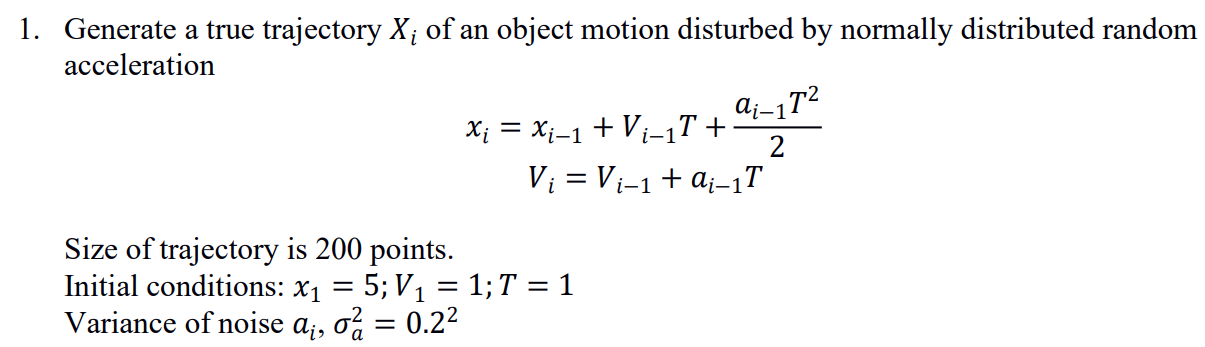

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [ ]:

# Initial conditions
x0 = 5
V0 = 1
T = 1
size_of_trajectory = 200
# Acceleration noise variance
sigma_a = 0.2**2

# Measurement noise variance
sigma_eta = 20**2

# Trajectory generation function
def generate_trajectory(size, x_init, v_init, T, sigma_a, sigma_eta):
    # Generate true trajectory, velocity and acceleration
    x = np.zeros(size)
    V = np.zeros(size)
    # Normally distributed random acceleration with zero mathematical expectation and variance sigma_w
    a = np.random.normal(0, np.sqrt(sigma_a), size-1)
    # Normally distributed random noise with zero mathematical expectation and variance sigma_eta
    eta = np.random.normal(0, np.sqrt(sigma_eta), size)
    # Trajectory generation
    for i in range(1, size):
        V[i] = V[i-1] + a[i-1] * T
        x[i] = x[i-1] + V[i-1] * T + a[i-1] * T**2 / 2
    # Measurements generation
    z = x + eta

    return x, V, z

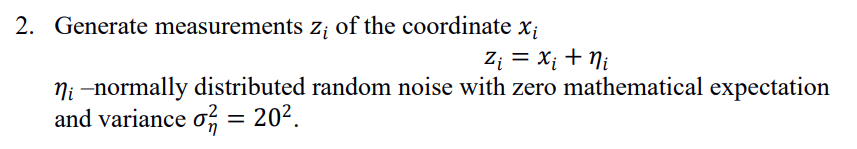

In [ ]:
x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)

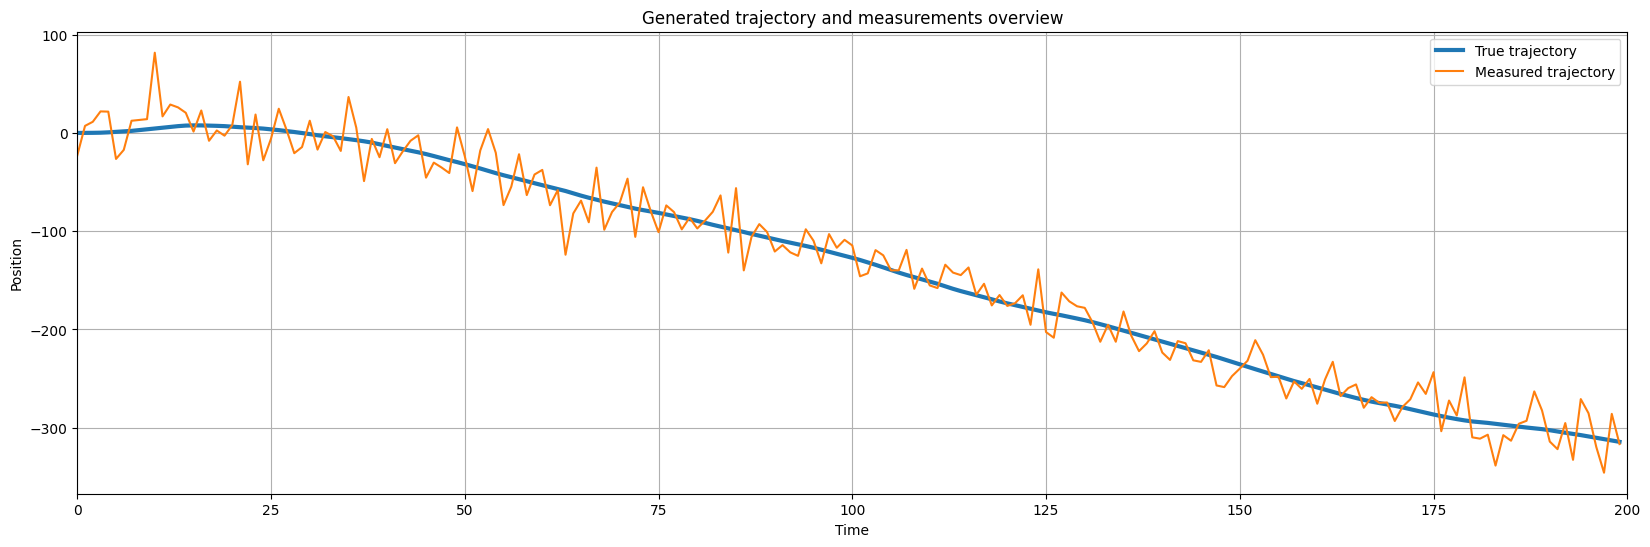

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.plot(x, label='True trajectory', linewidth = 3)
ax1.plot(z, label='Measured trajectory')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Generated trajectory and measurements overview')
plt.xlim([0, size_of_trajectory])
plt.legend()
plt.show()

Looks like we have a pretty noisy measurements with a lot of peaks from a true trajectory. And by looking at these peaks we can say that some advanced smoothing needed (**maybe some filtration who knows**).

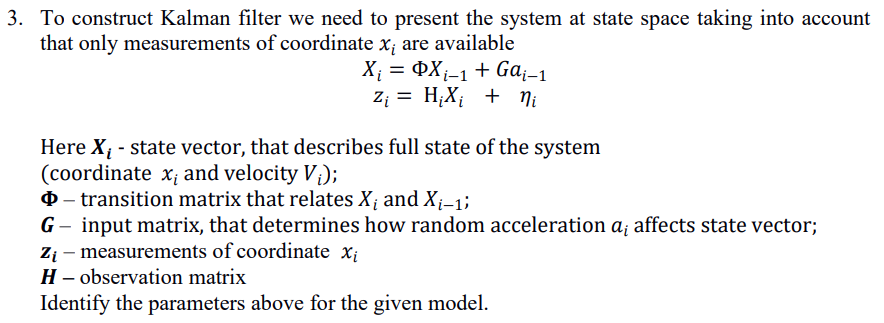

In [ ]:
# Transition matrix
Fi = np.array([[1, T],
              [0, 1]])

# Input matrix showing how random acceleration affects state vector
G = np.array([[T**2/2, T]]).T

# Observation matrix
H = np.array([[1.0, 0.0]])

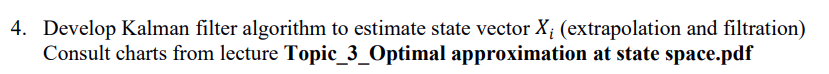

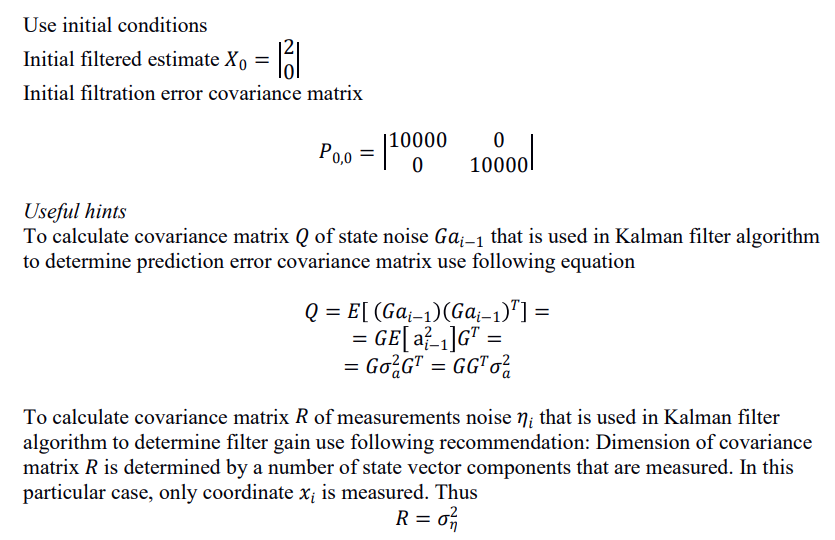

In [ ]:
# Initial conditions
X0 = np.array([2, 0]) # initial filtered estimate
P0 = np.array([[10000, 0], # Initial filtration error covariance matrix
                 [0, 10000]])

# covariance matrix of state noise
Q = G @ G.T * sigma_a

# covariance matrix of measurements noise
R = sigma_eta

In [ ]:
def Kalman(Fi, Q, H, R, X0, P0, z, m = 0, K_steady=None):
    size_of_trajectory = len(z)
    X = np.zeros((2, size_of_trajectory))
    X[:,0] = X0
    if m>0:
        X_extr = np.zeros((2, size_of_trajectory))
    P = P0
    if K_steady is None:
        K = np.zeros((2,))
    else:
        K = K_steady
    K_list = np.zeros((2, size_of_trajectory-1))
    sigma_x_list = []


    for i in range(1, size_of_trajectory):
        K_list[:, i-1] = K.flatten()
        sigma_x_list.append(P[0,0])
        # Prediction (extrapolation)
        X[:, i] = Fi @ X[:, i-1]
        if (m > 0):
          Fi_extr = Fi.copy()
          for _ in range(m-2):
            Fi_extr = Fi @ Fi_extr
          X_extr[:,i] = Fi_extr @ X[:, i-1]
        P = Fi @ P @ Fi.T + Q
        # Filtration
        if K_steady is None:
            K = P @ H.T * (H @ P @ H.T + R)**(-1)
        P = (np.eye(2) - K @ H) @ P
        X[:, i] = X[:, i] + (K * (z[i] - H @ X[:, i])).T
    if m > 0:
        return X, K_list, sigma_x_list, X_extr
    else:
        return X, K_list, sigma_x_list





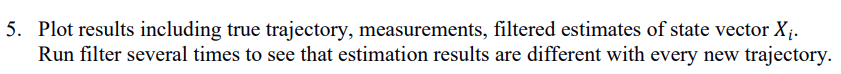

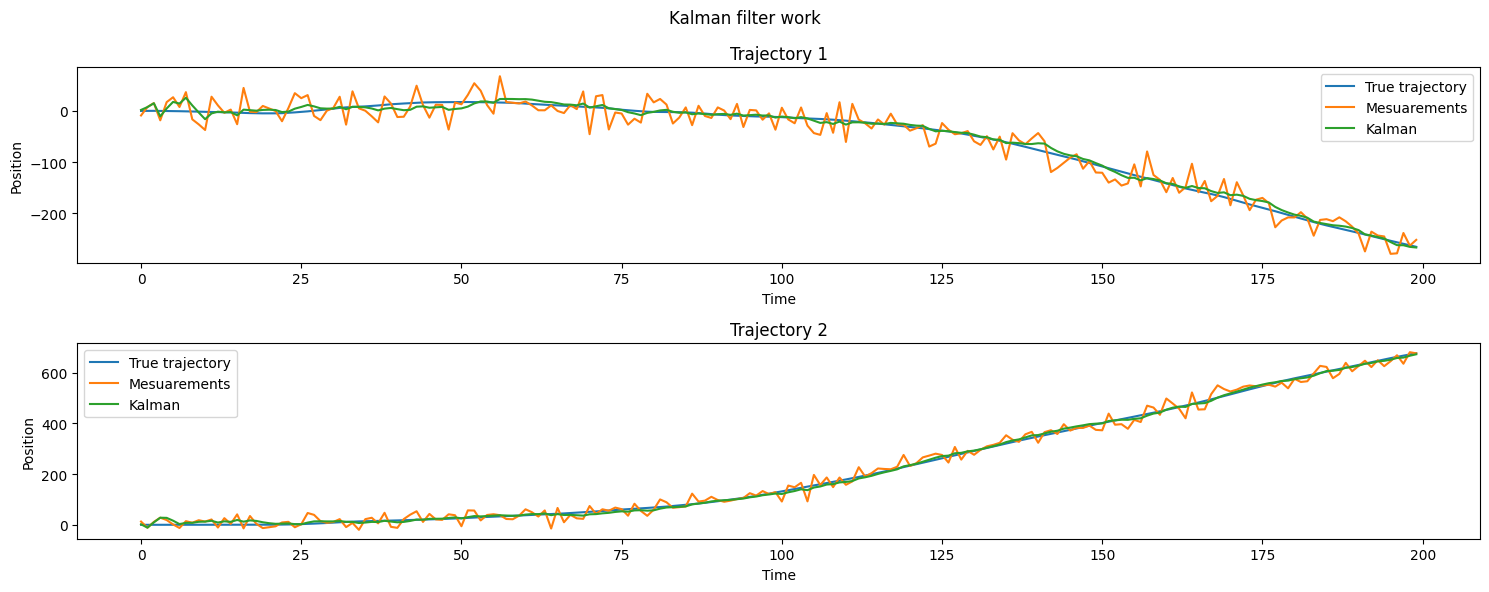

In [ ]:
plt.figure(figsize=(15,6))
plt.suptitle('Kalman filter work')

for i in range(1,3):
    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k  = Kalman(Fi, Q, H, R, X0, P0, z)
    plt.subplot(2,1,i)
    plt.plot(x, label = 'True trajectory')
    plt.plot(z, label = 'Mesuarements')
    plt.plot(X_k[0, :], label = 'Kalman')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title(f'Trajectory {i}')
    plt.legend()
plt.tight_layout()

As we can see from resulting plots, our **Kalman filter** implementation works and provides us with **smoothed** trajectory. In case of second trajectory we can say that Kalman values almost the same as the ground truth that indicates that we made right algorithm. We tried Kalman on **different** randomly generated measurements data and it works very well.

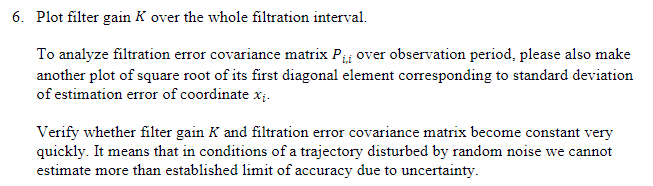

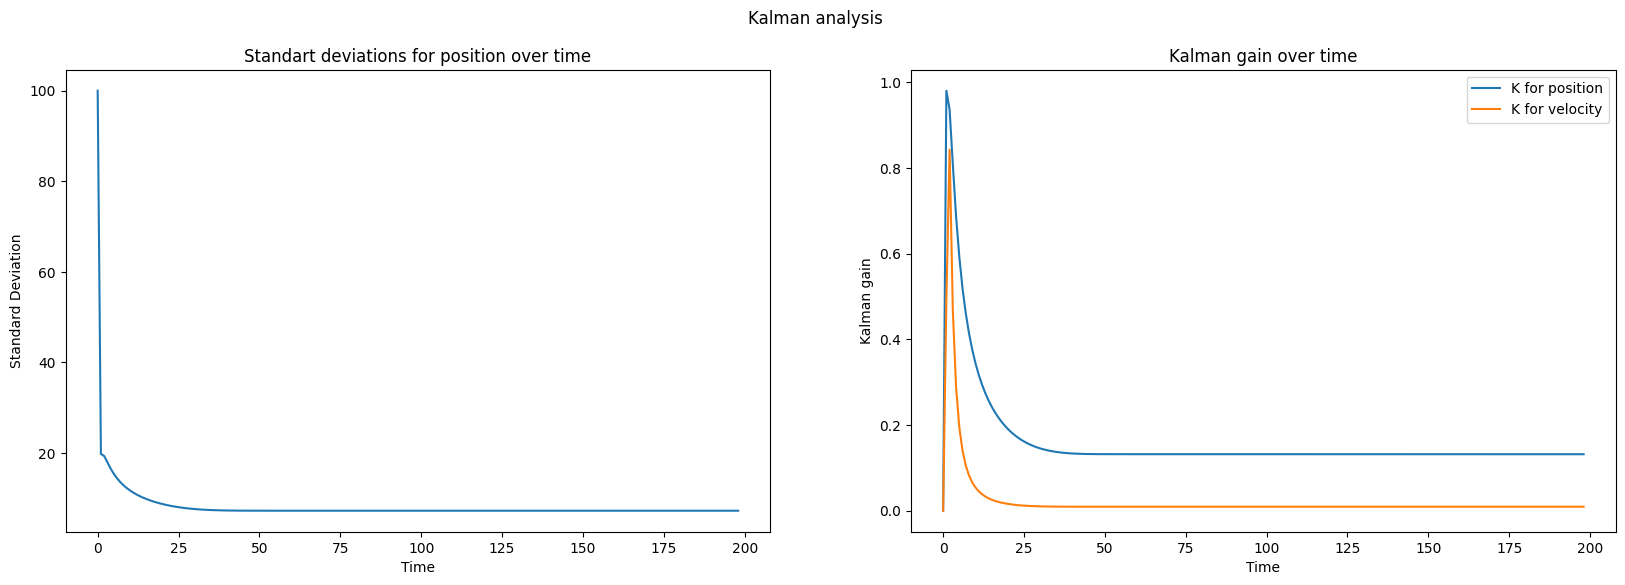

In [ ]:
plt.figure(figsize=(20,6))
plt.suptitle('Kalman analysis')
plt.subplot(121)
plt.title('Standart deviations for position over time')
plt.plot(np.sqrt(sigma_k))
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.subplot(122)
plt.title('Kalman gain over time')
plt.plot(gain[0,:], label='K for position')
plt.plot(gain[1,:], label='K for velocity')
plt.xlabel('Time')
plt.ylabel('Kalman gain')
plt.legend()

As we can see, the filter gain and standard deviation of x become constant very quickly. We cannot estimate the trajectory better than with **accuracy +-7** according to standard deviation.

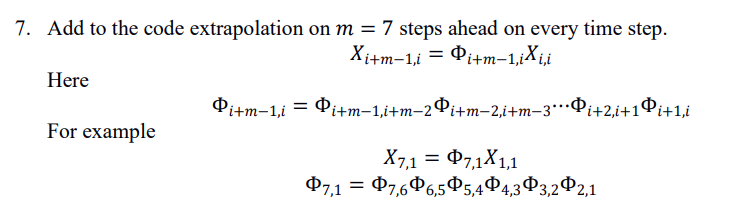

It was done for the Kalman function few cells before. We can use m parameter to define the extrapolation steps.

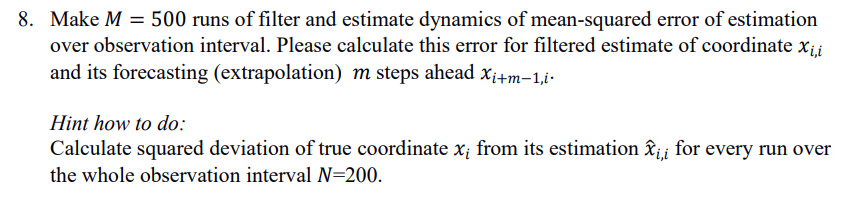

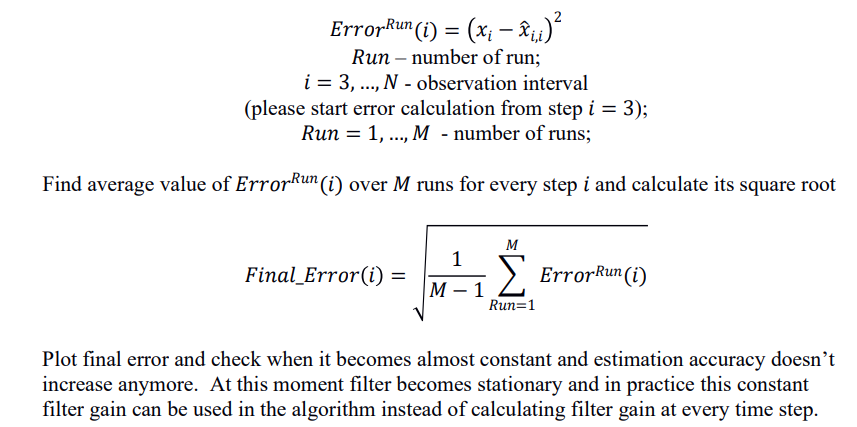

In [ ]:
# Num of runs
m=7
M = 500
mse_list = []
extrapolation_mse_list = []
measurement_std_list = []

for _ in range(M):
    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k, X_extrapolation  = Kalman(Fi, Q, H, R, X0, P0, z, m=m)

    error = (x[3:]-X_k[0,3:])**2
    #print(error.shape)
    mse_list.append(error)

    extrapolation_error = (x[m+3:]-X_extrapolation[0, 3:-m])**2
    extrapolation_mse_list.append(extrapolation_error)

    measurement_std = (z-x)**2
    measurement_std_list.append(measurement_std)

final_error = np.sqrt(sum(mse_list)/(M-1))
extrapolation_final_error = np.sqrt(sum(extrapolation_mse_list)/(M-1))
measurement_std = np.sqrt(sum(measurement_std_list)/(M-1))

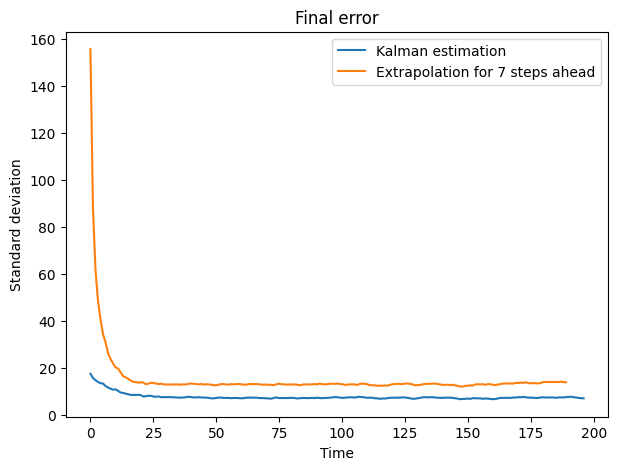

In [ ]:
plt.figure(figsize = (7,5))
plt.title('Final error')
plt.plot(final_error, label='Kalman estimation')
plt.plot(extrapolation_final_error, label=f'Extrapolation for {m} steps ahead')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

We definitely can say, that the Kalman filter **works fine** for 500 runs. Also we can notice that the standard deviation of the extrapolation for 7 steps closely approach standard deviation of the corrected Kalman output in ~20 timesteps. **And at this moment filter becomes stationary**, we are not oberving any **sufficient accuracy increase** after point of 25 timestep.

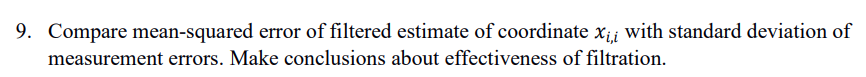

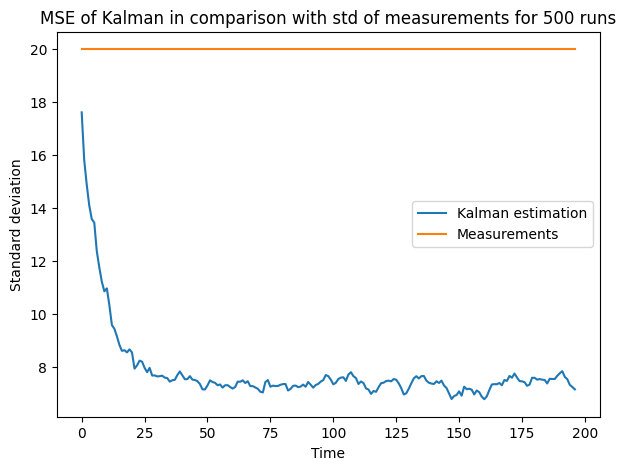

In [ ]:
plt.figure(figsize = (7,5))
plt.title(f'MSE of Kalman in comparison with std of measurements for {M} runs')
plt.plot(final_error, label='Kalman estimation')
plt.plot(np.ones_like(final_error)*np.sqrt(sigma_eta), label='Measurements')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

As we can see, we decreased the standard deviation of estimation in comparison with our noisy measurements by ~3 times. This resulting smoothed values are optimal and now can be used for some more advanced scientific calculations.

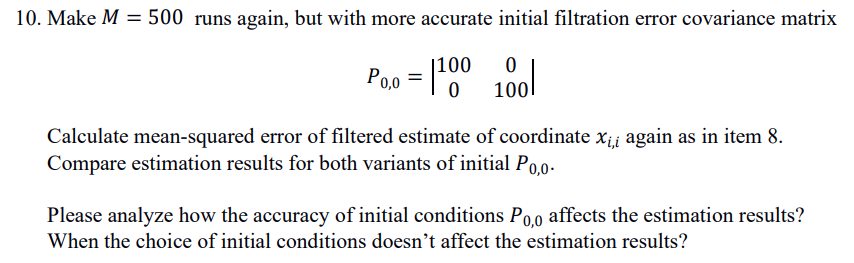

In [ ]:
P0 = np.array([[100, 0], # Initial filtration error covariance matrix
                 [0, 100]])
# Num of runs
M = 500
mse_list = []

for _ in range(M):
    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k = Kalman(Fi, Q, H, R, X0, P0, z)

    error = (x[3:]-X_k[0,3:])**2
    mse_list.append(error)

final_error_accurate = np.sqrt(sum(mse_list)/(M-1))

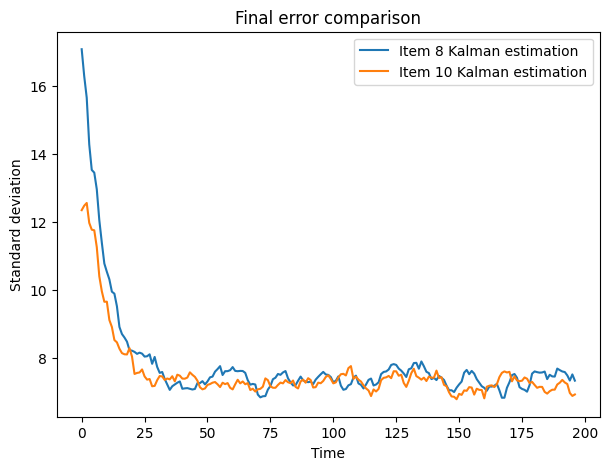

In [ ]:
plt.figure(figsize = (7,5))
plt.title('Final error comparison')
plt.plot(final_error, label='Item 8 Kalman estimation')
plt.plot(final_error_accurate, label=f'Item 10 Kalman estimation')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

Using more accurate initial filter covariance matrix allowed to achieve optimal Kalman gain in less iterations. Initial conditions doesn't affect the estimation results when the system is very predictable or the measurements is very accurate.

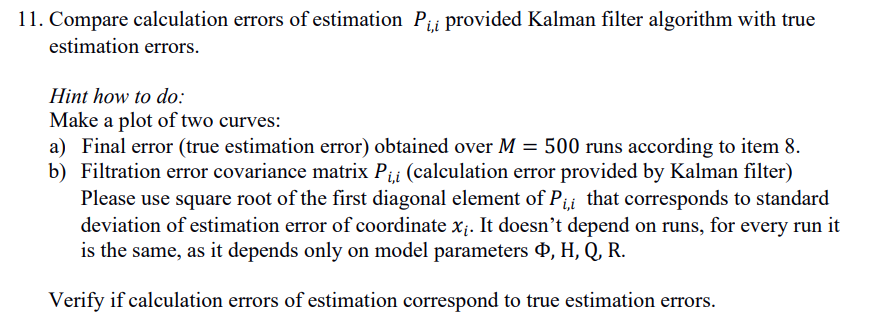

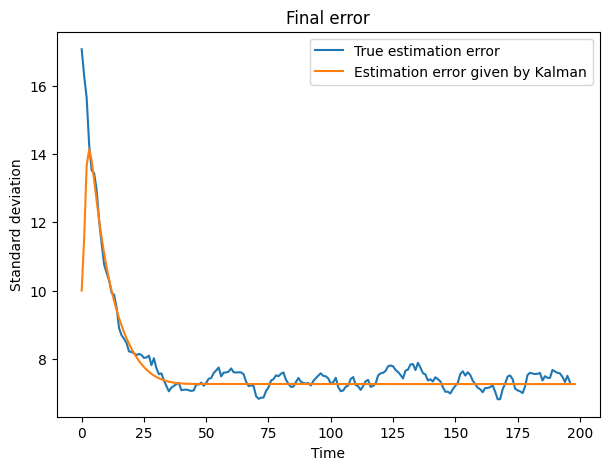

In [ ]:
plt.figure(figsize = (7,5))
plt.title('Final error')
plt.plot(final_error, label='True estimation error')
plt.plot(np.sqrt(sigma_k), label='Estimation error given by Kalman')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

As we can see, the calculation error correspond to true estimation errors.

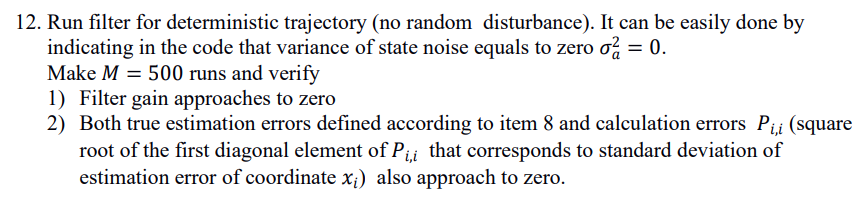

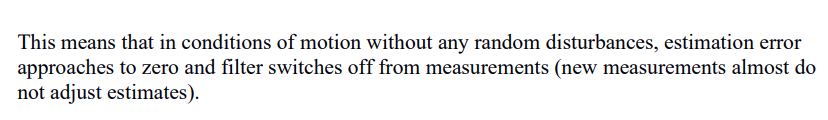

In [ ]:
M = 500
sigma_a = 0
Q = G @ G.T * sigma_a

error_8 = []

for _ in range(M):
    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k = Kalman(Fi, Q, H, R, X0, P0, z)

    error = (x[3:]-X_k[0,3:])**2
    error_8.append(error)

final_error = np.sqrt(sum(error_8)/(M-1))

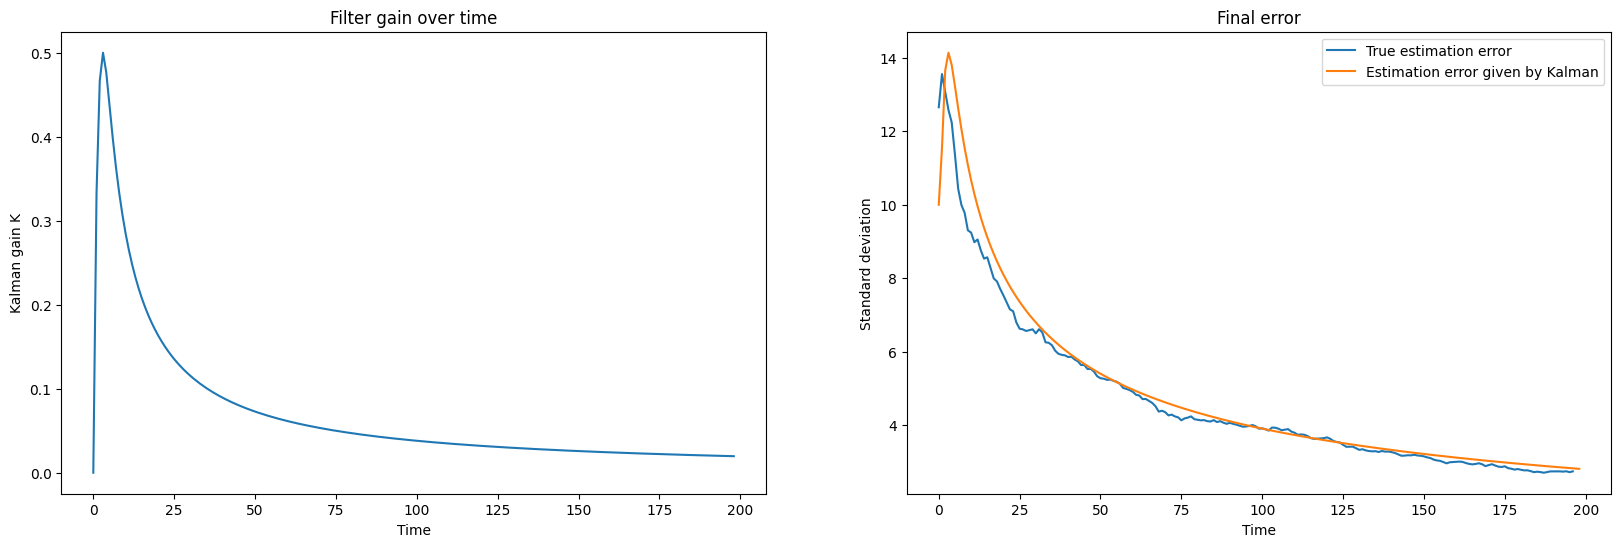

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title('Filter gain over time')
plt.xlabel('Time')
plt.ylabel('Kalman gain K')
plt.plot(gain[0,:], label = 'Filter gain')

plt.subplot(122)
plt.title('Final error')
plt.plot(final_error, label = 'True estimation error')
plt.plot(np.sqrt(sigma_k), label = 'Estimation error given by Kalman')
plt.plot()
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

We definitely can see, that the filter gain as well as estimation errors **approaches zero**. So we confirmed that that the filter switches off from the measurements.

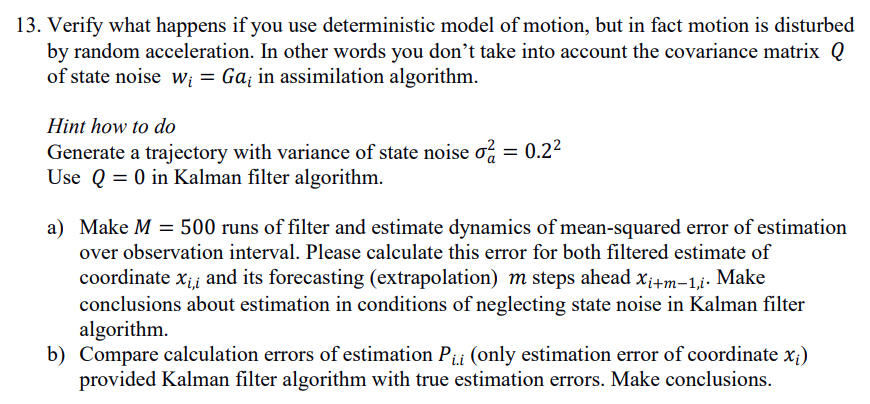

In [ ]:
M = 500
sigma_a = 0.2**2
Q = np.array([[0,0],
             [0,0]])

m=7
mse_list = []
extrapolation_mse_list = []

for _ in range(M):
    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k, X_extrapolation  = Kalman(Fi, Q, H, R, X0, P0, z, m=m)

    error = (x[3:]-X_k[0,3:])**2
    mse_list.append(error)

    extrapolation_error = (x[m+3:]-X_extrapolation[0, 3:-m])**2
    extrapolation_mse_list.append(extrapolation_error)

final_error = np.sqrt(sum(mse_list)/(M-1))
extrapolation_final_error = np.sqrt(sum(extrapolation_mse_list)/(M-1))

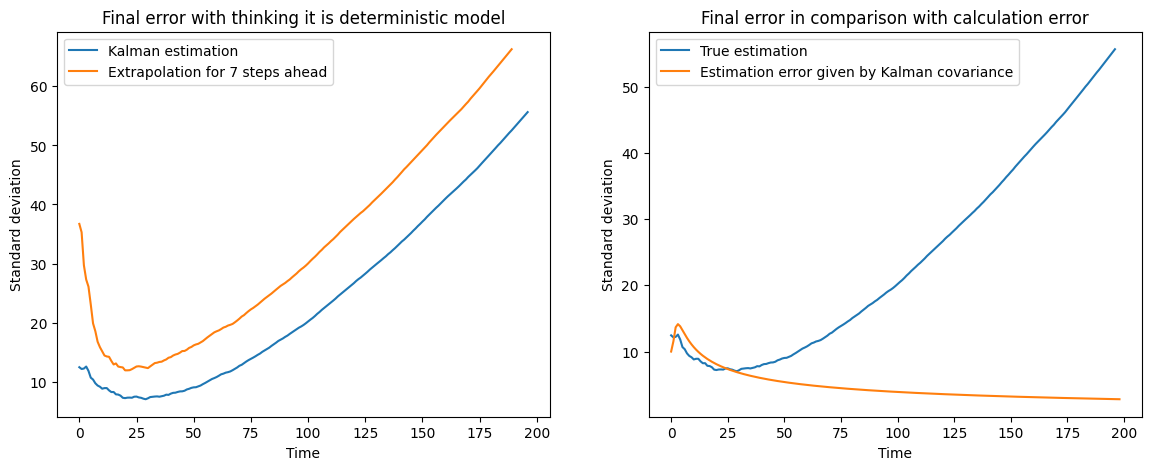

In [ ]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.title('Final error with thinking it is deterministic model')
plt.plot(final_error, label='Kalman estimation')
plt.plot(extrapolation_final_error, label=f'Extrapolation for {m} steps ahead')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

plt.subplot(122)
plt.title('Final error in comparison with calculation error')
plt.plot(final_error, label='True estimation')
plt.plot(np.sqrt(sigma_k), label='Estimation error given by Kalman covariance')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.legend()

The filter diverges since we have a random acceleration we don't care about. Kalman algorithm "thinks" that we are actually found our best value but it's not.

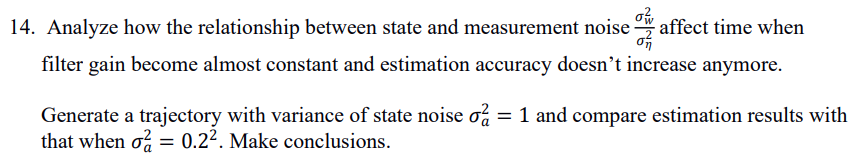

In [ ]:
sigma_a_traj1 = 1
sigma_a_traj2 = 0.2**2

# covariance matrix of state noise
Q_traj1 = G @ G.T * sigma_a_traj1
Q_traj2 = G @ G.T * sigma_a_traj2

mse_list_1 = []
mse_list_2 = []
for _ in range(M):
    # Trajectory generation
    x_traj1, v_traj1, z_traj1 = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a_traj1, sigma_eta)
    x_traj2, v_traj2, z_traj2 = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a_traj2, sigma_eta)

    # Kalman filtration
    x_filtered1, gain_traj1, sigma_k_traj1  = Kalman(Fi, Q_traj1, H, R, X0, P0, z_traj1)
    x_filtered2, gain_traj2, sigma_k_traj2  = Kalman(Fi, Q_traj2, H, R, X0, P0, z_traj2)

    error = (x_traj1[3:]-x_filtered1[0,3:])**2
    mse_list_1.append(error)

    error = (x_traj2[3:]-x_filtered2[0,3:])**2
    mse_list_2.append(error)

final_error_1 = np.sqrt(sum(mse_list_1)/(M-1))
final_error_2 = np.sqrt(sum(mse_list_2)/(M-1))

In [ ]:
final_error_1

array([13.24568981, 13.5126033 , 12.93666097, 11.93207765, 11.75464573,
       11.26041314, 10.84770239, 10.41677911, 10.60670384, 10.50922675,
       10.53125092, 10.42011206, 10.688645  , 10.73599144, 10.90288436,
       10.51327092, 10.66912294, 10.5164874 , 10.29774024, 10.35740978,
       10.24914451, 10.3753725 , 10.03322443, 10.26947118, 10.16423763,
       10.35296987, 10.24562204, 10.62103001, 10.60769709, 10.40489601,
       10.25347724, 10.39893367, 10.48258702, 10.471046  , 10.73921392,
       10.79765306, 11.26233448, 10.90379916, 10.55736219, 10.58301548,
       10.19804248, 10.30335007, 10.13930057, 10.29219989, 10.68391897,
       10.76832697, 10.9460139 , 10.89180179, 10.65810862, 10.8198364 ,
       10.75899653, 10.73364085, 10.78048922, 11.04827557, 10.80363482,
       10.51432547, 11.14755567, 10.72676177, 10.77323689, 10.61343992,
       10.55852178, 10.58232431, 10.5656424 , 10.98265911, 10.8760389 ,
       10.99730503, 10.71947901, 10.48090665, 10.50590977, 10.46

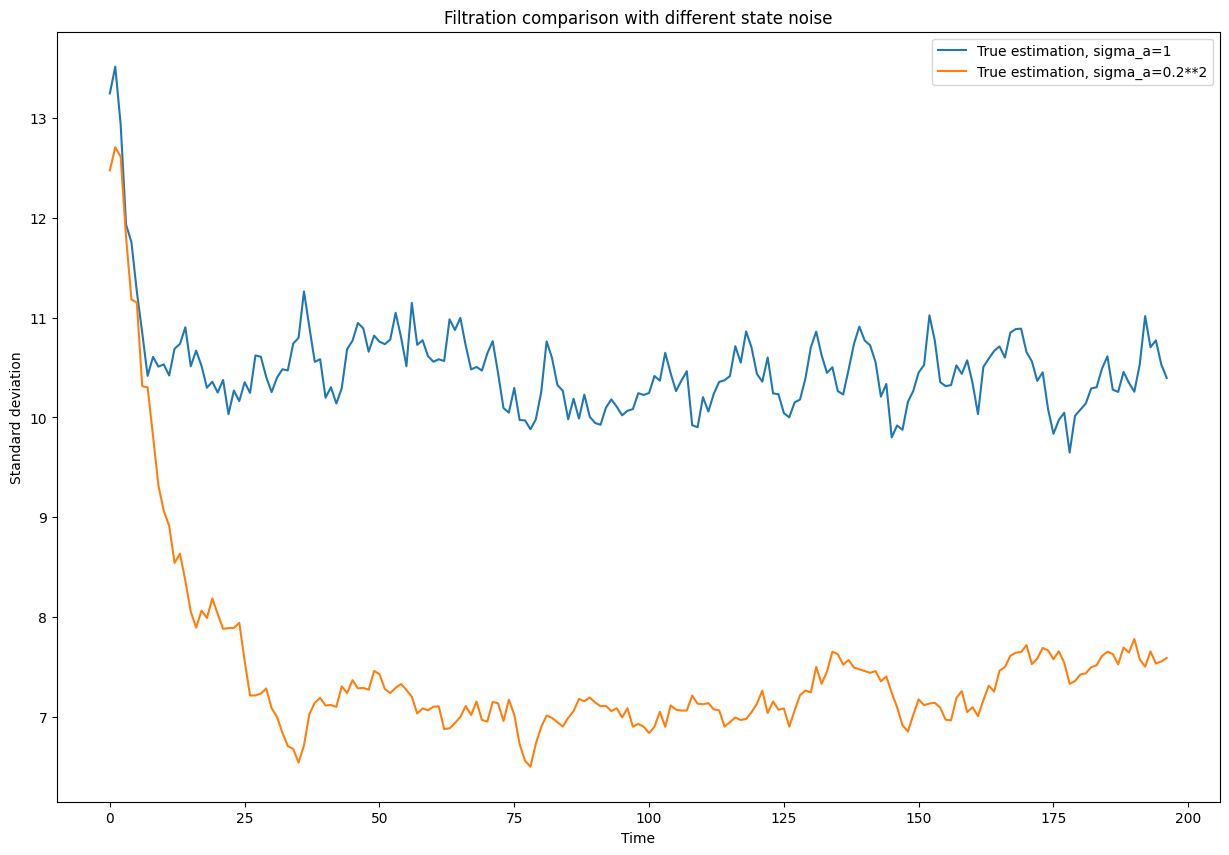

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(final_error_1, label='True estimation, sigma_a=1')
plt.plot(final_error_2, label='True estimation, sigma_a=0.2**2')
plt.title('Filtration comparison with different state noise')
plt.xlabel('Time')
plt.ylabel('Standard deviation')

plt.legend()
plt.show()

As we can see, the low state noise allowed to achieve better results but in a **larger number of iteration**.

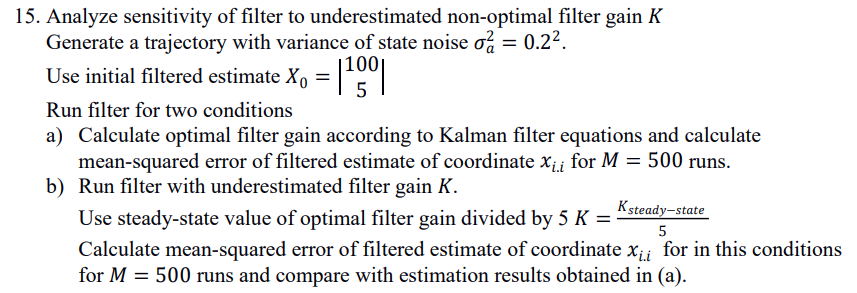

In [ ]:
sigma_a = 0.2**2
Q = G @ G.T * sigma_a
X0 = np.array([100, 5]) # initial filtered estimate

M = 500 # Num of runs


# Optimal Kalman gain "calculation"
X_k, gain, sigma_k = Kalman(Fi, Q, H, R, X0, P0, z)
K = gain[:,-1].reshape(2,1)

mse_list = []
underestimated_mse_list = []
for _ in range(M):
    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k = Kalman(Fi, Q, H, R, X0, P0, z, K_steady = K)

    error = (x[3:]-X_k[0,3:])**2
    mse_list.append(error)

    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_k, gain, sigma_k = Kalman(Fi, Q, H, R, X0, P0, z, K_steady = K/5)

    error = (x[3:]-X_k[0,3:])**2
    underestimated_mse_list.append(error)

final_error = np.sqrt(sum(mse_list)/(M-1))
underestimated_final_error = np.sqrt(sum(underestimated_mse_list)/(M-1))

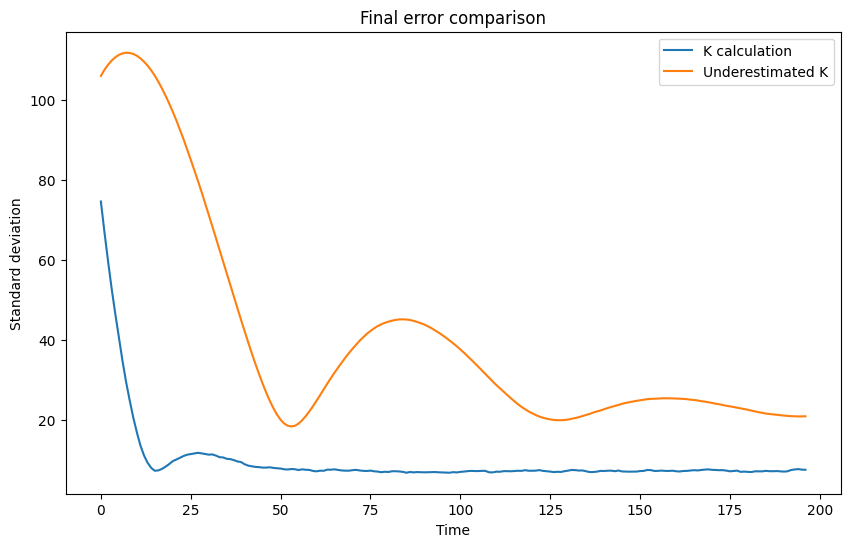

In [ ]:

plt.figure(figsize=(10,6))
plt.title('Final error comparison')
plt.plot(final_error, label = 'K calculation')
plt.plot(underestimated_final_error, label = 'Underestimated K')
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.legend()

As expected the understimated Kalman gain showed bad performance in comparison with optimal value.

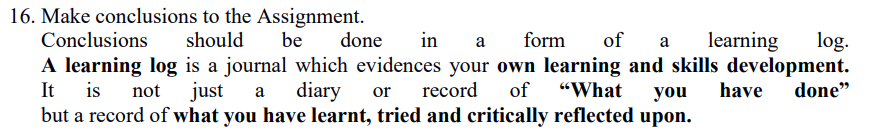

<b>Conclusion</b>: In this big assignment we actually dived into the linear Kalman filter algorithm. In each item we actually learned something new about the Kalman filter properties, parameters and their dependance on the real data. First of all the whole Kalman filter algorithm construction was a new experience using these **libraries**. We learned that numpy syntaxis can be tricky sometimes, we was checking matrices shape **almost every step** during Kalman filter development. Next, we figured out how to plot subplots, so now it look way cooler, when we can see comparison of true/measurements/smoothed values of different trajectories in one cell **without sequence of plot-cells**. And good practice for us was playing with parameters of the model and model itself. Task with applying our filter on determenistic model was very representative and showed us importance of the **right tools** choice.